<a href="https://colab.research.google.com/github/waterism211/Variational_Inference/blob/master/median_gmm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## GMMOT

### functions

In [ ]:
pip install POT

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 kB 4.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import ot
import scipy.stats as sps
import scipy.linalg as spl
from scipy.optimize import linprog
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist, euclidean

#################
### author : Julie Delon
#################

###############################
#### display GMM
###############################


def display_gmm(gmm,n=50,ax=0,bx=1,ay=0,by=1,cmap='viridis',axis=None):

    if axis is None:
        axis = plt.gca()

    [K,pi,mu,S] = gmm

    x = np.linspace(ax, bx,num=n)
    y = np.linspace(ay, by,num=n)
    X, Y = np.meshgrid(x, y)
    XX = np.array([X.ravel(), Y.ravel()]).T
    Z = densite_theorique2d(mu,S,pi,XX)
    Z = Z.reshape(X.shape)
    plt.axis('equal')
    return axis.contour(X, Y, Z,8,cmap=cmap)





###############################
#### compute GMM densities
###############################

def densite_theorique(mu,var,alpha,x):
    # compute the 1D GMM density with parameters (mu,var) and weights alpha  at x
    K=mu.shape[0]
    y=0
    #y=np.zeros(len(x))
    for j in range(K):
        y+=alpha[j]*sps.norm.pdf(x,loc=mu[j,:],scale=np.sqrt(var[j,:,:]))
    return y.reshape(x.shape)

def densite_theorique2d(mu,Sigma,alpha,x):
    # compute the 2D GMM density with parameters (mu, Sigma) and weights alpha at x
    K = mu.shape[0]
    alpha = alpha.reshape(1,K)
    y=0
    for j in range(K):
        y+=alpha[0,j]*sps.multivariate_normal.pdf(x,mean=mu[j,:],cov=Sigma[j,:,:])
    return y

###############################
### Optimal Transport between Gaussians (quadratic Wasserstein)
###############################

def geometric_median(X, eps=1e-5):
    y = np.mean(X, 0)

    while True:
        D = cdist(X, [y])
        nonzeros = (D != 0)[:, 0]

        Dinv = 1 / D[nonzeros]
        Dinvs = np.sum(Dinv)
        W = Dinv / Dinvs
        T = np.sum(W * X[nonzeros], 0)

        num_zeros = len(X) - np.sum(nonzeros)
        if num_zeros == 0:
            y1 = T
        elif num_zeros == len(X):
            return y
        else:
            R = (T - y) * Dinvs
            r = np.linalg.norm(R)
            rinv = 0 if r == 0 else num_zeros/r
            y1 = max(0, 1-rinv)*T + min(1, rinv)*y

        if euclidean(y, y1) < eps:
            return y1

        y = y1


def GaussianW2(m0,m1,Sigma0,Sigma1):
    # compute the quadratic Wasserstein distance between two Gaussians with means m0 and m1 and covariances Sigma0 and Sigma1
    Sigma00  = spl.sqrtm(Sigma0)
    Sigma010 = spl.sqrtm(Sigma00@Sigma1@Sigma00)
    d        = np.linalg.norm(m0-m1)**2+np.trace(Sigma0+Sigma1-2*Sigma010)
    return d

def GaussianW2_1D(m0, m1, Sigma0, Sigma1):
    # Compute the quadratic Wasserstein distance between two 1D Gaussians with means m0 and m1 and variances Sigma0 and Sigma1
    d = (m0 - m1)**2 + (np.sqrt(Sigma0) - np.sqrt(Sigma1)) ** 2
    return d


def GaussianMap(m0,m1,Sigma0,Sigma1,x):
    # Compute the OT map (evaluated at x) between two Gaussians with means m0 and m1 and covariances Sigma0 and Sigma1
    # m0 and m1 must be 2D arrays of size 1xd
    # Sigma0 and Sigma1 must be 2D arrays of size dxd
    # x can be a matrix of size n x d,
    # each column of x is a vector to which the function is applied
    d = Sigma0.shape[0]
    m0 = m0.reshape(1,d)
    m1 = m1.reshape(1,d)
    Sigma0 = Sigma0.reshape(d,d)
    Sigma1 = Sigma1.reshape(d,d)
    Sigma  = np.linalg.inv(Sigma0)@spl.sqrtm(Sigma0@Sigma1)
    Tx        = m1+(x-m0)@Sigma
    return Tx


import numpy as np
import scipy.linalg as spl

def GaussianBarycenterW2_1D(mu, Sigma, alpha, N):
    # Compute the W2 barycenter between several 1D Gaussians
    # mu has size K, with K the number of Gaussians
    # Sigma has size K
    K = mu.shape[0]  # number of Gaussians
    Sigman = 1.0
    mun = 0.0
    cost = 0

    for n in range(N):
        T = 0.0
        for j in range(K):
            T += alpha[j] * np.sqrt(Sigman * Sigma[j])
        Sigman = T**2

    for j in range(K):
        mun += alpha[j] * mu[j]

    for j in range(K):
        cost += alpha[j] * GaussianW2_1D(mu[j], mun, Sigma[j], Sigman)

    return mun, Sigman, cost

# Note: The function GaussianW2_1D needs to be defined to compute the W2 distance for 1D Gaussians.


def GaussianBarycenterW2(mu,Sigma,alpha,N):
    # Compute the W2 barycenter between several Gaussians
    # mu has size Kxd, with K the number of Gaussians and d the space dimension
    # Sigma has size Kxdxd
    K        = mu.shape[0]  # number of Gaussians
    d        = mu.shape[1]  # size of the space
    Sigman   = np.eye(d,d)
    mun      = np.zeros((1,d))
    cost = 0

    for n in range(N):
        Sigmandemi       = spl.sqrtm(Sigman)
        T = np.zeros((d,d))
        for j in range(K):
            T+= alpha[j]*spl.sqrtm(Sigmandemi@Sigma[j,:,:]@Sigmandemi)
        Sigman  = T


    mun = geometric_median(np.array(mu), eps=1e-5)

    for j in range(K):
        cost+= alpha[j]*GaussianW2(mu[j,:],mun,Sigma[j,:,:],Sigman)

    return mun,Sigman,cost       # return the Gaussian Barycenter (mun,Sigman) and the total cost

###############################
###### GW2 between GMM
###############################


def GW2(pi0,pi1,mu0,mu1,S0,S1):
    # return the GW2 discrete map and the GW2 distance between two GMM
    K0 = mu0.shape[0]
    K1 = mu1.shape[0]
    d  = mu0.shape[1]
    S0 = S0.reshape(K0,d,d)
    S1 = S1.reshape(K1,d,d)
    M  = np.zeros((K0,K1))
    # First we compute the distance matrix between all Gaussians pairwise
    for k in range(K0):
        for l in range(K1):
            M[k,l]  = GaussianW2(mu0[k,:],mu1[l,:],S0[k,:,:],S1[l,:,:])
    # Then we compute the OT distance or OT map thanks to the OT library
    wstar     = ot.emd(pi0,pi1,M)         # discrete transport plan
    distGW2   = np.sum(wstar*M)
    return wstar,distGW2

def GW2cost(mu0,mu1,S0,S1):       # return the distance matrix M of size K0 x K1
    K0 = mu0.shape[0]
    K1 = mu1.shape[0]
    M = np.zeros((K0,K1))
    # we compute the distance matrix between all Gaussians pairwise
    for k in range(K0):
        for l in range(K1):
            M[k,l]  = GaussianW2(mu0[k,:],mu1[l,:],S0[k,:,:],S1[l,:,:])
    return M

def GW2_map(pi0,pi1,mu0,mu1,S0,S1,wstar,x):
    # return the GW2 maps between two GMM on the 1D grid x
    n,K0,K1    = x.shape[0],mu0.shape[0],mu1.shape[0]
    T          = np.zeros((K0,K1,n))     # each Tkl = T[k,l,:] is of dimension n and correspond to the W2-map between component k of mu0 and component l of mu1
    tmpmean    = np.zeros(n)
    weightmean = np.zeros(n)
    Tmean      = np.zeros((n,n))     # averaged map on a grid
    Tmap       = np.zeros((n,n))     # multivalued map on a grid

    for k in range(K0):
        for l in range(K1):
            if wstar[k,l]!=0:
                T[k,l,:] = GaussianMap(mu0[k,:],mu1[l,:],S0[k,],S1[l],x).reshape(n,)
                for i in range(n):
                    Ti             = int(max(min(T[k,l,i],1),0)*99)
                    Tmap[i,Ti]    += wstar[k,l]*sps.norm.pdf(x[i],loc=mu0[k],scale=np.sqrt(S0[k]))
                    tmpmean[i]    += wstar[k,l]*sps.norm.pdf(x[i],loc=mu0[k],scale=np.sqrt(S0[k]))/densite_theorique(mu0,S0,pi0,x[i])*T[k,l,i]
                    weightmean[i] += wstar[k,l]*sps.norm.pdf(x[i],loc=mu0[k],scale=np.sqrt(S0[k]))

    tmpmean = np.uint(np.maximum(np.minimum(tmpmean,1),0)*99)
    for i in range(n):
        Tmean[i,tmpmean[i]] = weightmean[i]

    return Tmap,Tmean


#####################################################
##### Multimarginal problem
#####################################################


def create_cost_matrix_from_gmm(gmm,alpha,N=10):
    """
    create the cost matrix for the multimarginal problem between all GMM
    create the barycenters (mun,Sn) betweenn all Gaussian components
    """

    nMarginal       = len(alpha)               # number of marginals
    d               = gmm[0][2].shape[1]       # space dimension
    tup = ();
    for k in range(nMarginal):
        K  = gmm[k][0]
        tup+=(K,)
    C               = np.zeros(tup)
    mun             = np.zeros(tup+(d,))
    Sn             = np.zeros(tup+(d,d))

    it = np.nditer(C,["multi_index"])
    while not it.finished:
        tup = it.multi_index
        mu = np.zeros((nMarginal,d))
        Sigma = np.zeros((nMarginal,d,d))

        for k in range(nMarginal):
            mu[k,:]      = gmm[k][2][tup[k]]
            Sigma[k,:,:] = gmm[k][3][tup[k]]

        mu    = np.array(mu)
        Sigma = np.array(Sigma)
        [mun[tup],Sn[tup],cost] = GaussianBarycenterW2(mu,Sigma,alpha,N)

        C[tup] = cost

        it.iternext()

    return C,mun,Sn

def solveMMOT(pi, costMatrix, epsilon = 1e-10):
    """ Author : Alexandre Saint-Dizier

    Solveur of the MultiMargnal OT problem, using linprog

    Input :
     - pi : list(array) -> weights of the different distributions
     - C : array(d1,...dp) -> cost matrix
     - epsilon : smallest value considered to be positive

    Output :
     - gamma : list of combinaison with positive weight
     - gammaWeights : corresponding weights
    """

    nMarginal = len(pi);
    nPoints = costMatrix.shape;

    nConstraints = 0; nParameters = 1;
    for ni in nPoints:
        nConstraints += ni; nParameters *= ni

    index = 0;
    A = np.zeros((nConstraints, nParameters)); b = np.zeros(nConstraints)
    for i in range(nMarginal):
        ni = nPoints[i];
        b[index:index+ni] = pi[i];
        for k in range(ni):
            Ap = np.zeros(costMatrix.shape);
            tup = ();
            for j in range(nMarginal):
                if j==i:
                    tup+= (k,)
                else:
                    tup+=(slice(0,nPoints[j]),)
            Ap[tup] = 1;
            A[index+k,:]=Ap.flatten();
        index += ni
    A = A.tolist(); b = b.tolist();
    C = costMatrix.flatten().tolist()

    res = linprog(C, A_eq=A, b_eq =b) #Solve inf <C,X> with constraints AX=b
    gammaWeights = res.x;
    gammaWeights = gammaWeights.reshape(costMatrix.shape)

    return gammaWeights







####################################################
#### for color transfer or color barycenters   #####
#### guided_filter is used for post-processing #####
####################################################


def average_filter(u,r):
    # uniform filter with a square (2*r+1)x(2*r+1) window
    # u is a 2d image
    # r is the radius for the filter

    (nrow, ncol)                                      = u.shape
    big_uint                                          = np.zeros((nrow+2*r+1,ncol+2*r+1))
    big_uint[r+1:nrow+r+1,r+1:ncol+r+1]               = u
    big_uint                                          = np.cumsum(np.cumsum(big_uint,0),1)       # integral image

    out = big_uint[2*r+1:nrow+2*r+1,2*r+1:ncol+2*r+1] + big_uint[0:nrow,0:ncol] - big_uint[0:nrow,2*r+1:ncol+2*r+1] - big_uint[2*r+1:nrow+2*r+1,0:ncol]
    out = out/(2*r+1)**2

    return out

def guided_filter(u,guide,r,eps):
    C           = average_filter(np.ones(u.shape), r)   # to avoid image edges pb
    mean_u      = average_filter(u, r)/C
    mean_guide  = average_filter(guide, r)/C
    corr_guide  = average_filter(guide*guide, r)/C
    corr_uguide = average_filter(u*guide, r)/C
    var_guide   = corr_guide - mean_guide * mean_guide
    cov_uguide  = corr_uguide - mean_u * mean_guide

    alph = cov_uguide / (var_guide + eps)
    beta = mean_u - alph * mean_guide

    mean_alph = average_filter(alph, r)/C
    mean_beta = average_filter(beta, r)/C

    q = mean_alph * guide + mean_beta
    return q

import scipy.stats as sps

def calculate_coverage(data, gmm, threshold=0.95):
    weights, means, covars = gmm[1], gmm[2], gmm[3]
    total_prob = np.zeros(data.shape[0])

    for weight, mean, covar in zip(weights.flatten(), means, covars):
        rv = sps.multivariate_normal(mean, covar)
        total_prob += weight * rv.pdf(data)

    # Determine the density threshold that captures the desired percentage of data
    density_threshold = np.percentile(total_prob, 100 * (1 - threshold))

    # Calculate coverage as the percentage of points above the threshold
    coverage = np.mean(total_prob > density_threshold)
    return coverage

## load the data for each magnitude of outlier

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


def coverage_level(Z, pi, coverage=0.95):
    # Flatten the density matrix and sort it
    sorted_Z = np.sort(Z.ravel())[::-1]
    # Compute the cumulative density
    cumulative_density = np.cumsum(sorted_Z) / np.sum(sorted_Z)
    # Find the minimum density level that includes at least the 'coverage' fraction of total density
    return sorted_Z[np.argmax(cumulative_density >= coverage)]

def display_gmm_data(gmm, data=None, coverage=0.95, n=50, ax=0, bx=1, ay=0, by=1, cmap='viridis', axis=None):
    if axis is None:
        axis = plt.gca()

    [K, pi, mu, S] = gmm

    x = np.linspace(ax, bx, num=n)
    y = np.linspace(ay, by, num=n)
    X, Y = np.meshgrid(x, y)
    XX = np.array([X.ravel(), Y.ravel()]).T
    Z = densite_theorique2d(mu, S, pi, XX)
    Z = Z.reshape(X.shape)

    # Determine the contour level for the specified coverage
    level = coverage_level(Z, pi, coverage)

    # Plot the full density contour and the coverage contour
    contour_full = axis.contour(X, Y, Z, levels=8, cmap=cmap)
    contour_coverage = axis.contour(X, Y, Z, levels=[level], colors='red', linewidths=2.5, linestyles='dashed')
    axis.set_aspect('equal')

    # Plot data points if provided
    if data is not None:
        axis.scatter(data['X1'], data['X2'], s=5, c='blue', label='Data Points')
        axis.legend()

    return contour_full, contour_coverage

In [ ]:
def loaddatasetfromcvs(file):
    for i in range(1,26):
        gmm_result_df = pd.read_csv(file, delimiter=",")
        mus = []
        pis = []
        sigmas = []
        K = 2

        for i in range(0, 70, 7):  # Iterating with the correct pattern
            # Extract 'mu'
            mu = np.transpose(gmm_result_df.iloc[i:i+2, :].values)
            mus.append(mu)

            # Extract 'pi'
            pi = gmm_result_df.iloc[i + 2, :].values
            pis.append(pi)

            # Extract and reconstruct 'sigma'
            sigma_iteration = []
            for j in range(K):
                sigma_values = []
                sigma_values  = gmm_result_df.iloc[i+3:i+7,j].values
                sigma_values = sigma_values.reshape((2,2))
                #sigma_values = sigma_values*10**(1/2)
                sigma_iteration.append(sigma_values)
            sigmas.append(sigma_iteration)

        # Showing the corrected first 'mu', 'pi', and the first 'sigma' matrix for the first cluster of the first iteration for verification
        mus[0], pis[0], sigmas[0]

        pis_array = np.array(pis)
        gmm_list = []
        for i in range(len(mus)):
            sigmas[i] = np.stack(sigmas[i], axis=0)
            gmm_list.append([K,pis[i], mus[i], sigmas[i]])

    return pis_array, gmm_list


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import torch
torch.manual_seed(0)
path = "/content/drive/MyDrive/VI_median"
import pandas as pd
import numpy as np
gmminterp = []

Mounted at /content/drive


In [ ]:

from google.colab import drive
drive.mount('/content/drive')
import torch
torch.manual_seed(0)
path = "/content/drive/MyDrive/VI_median"
import pandas as pd
import numpy as np
gmminterp = []
for i in range(1,26):
    file = f"/content/drive/MyDrive/VI/gmm_result{i}.csv"
    pis_array, gmm_list = loaddatasetfromcvs(file)
    K = 2
    Kn = pow(K,10)
    d = 2
    # Define the weights for the GMMs in the barycenter calculation
    alpha = np.full(10,1/10)

    C,mun,Sn   = create_cost_matrix_from_gmm(gmm_list,alpha)
    pin        = solveMMOT(pis_array, C, epsilon = 1e-10).reshape(1,Kn)
    mun,Sn     = mun.reshape(Kn,d),Sn.reshape(Kn,d,d)
    gmminterp.append([Kn,pin,mun,Sn])


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


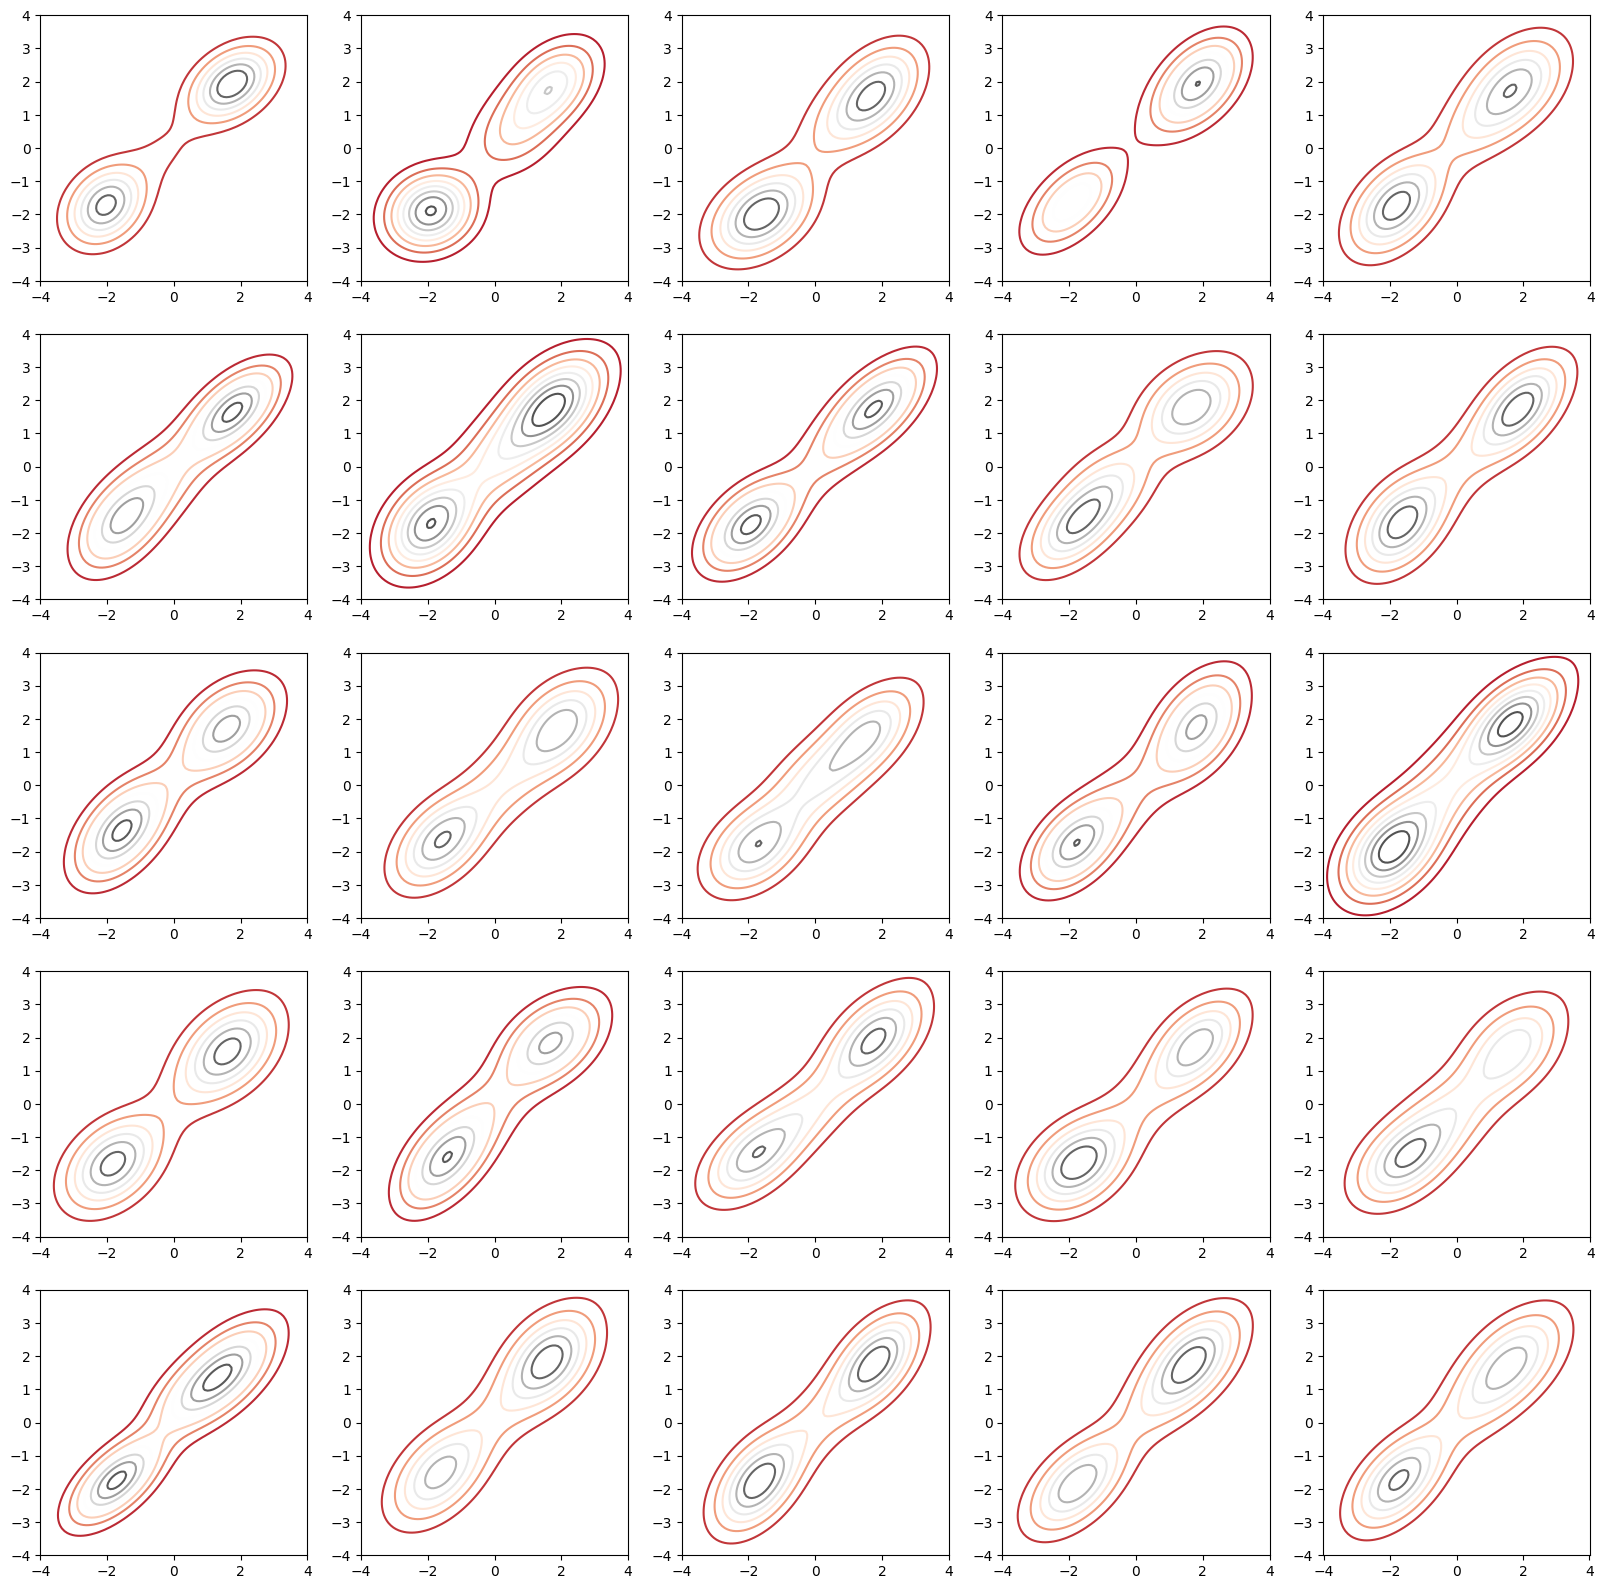

In [ ]:
fig, axs = plt.subplots(5, 5, figsize=(20, 20))

for ax, gmm in zip(axs.ravel(), gmminterp):
    display_gmm(gmm, n=100, ax=-4, bx=4, ay=-4, by=4, cmap='RdGy', axis=ax)

plt.show()

load the original data points

In [ ]:
datapoints = []
for i in range(1,26):
    file = f"/content/drive/MyDrive/VI/dataset{i}.csv"
    datapoint = pd.read_csv(file, delimiter=",")
    datapoints.append(datapoint[0:199])

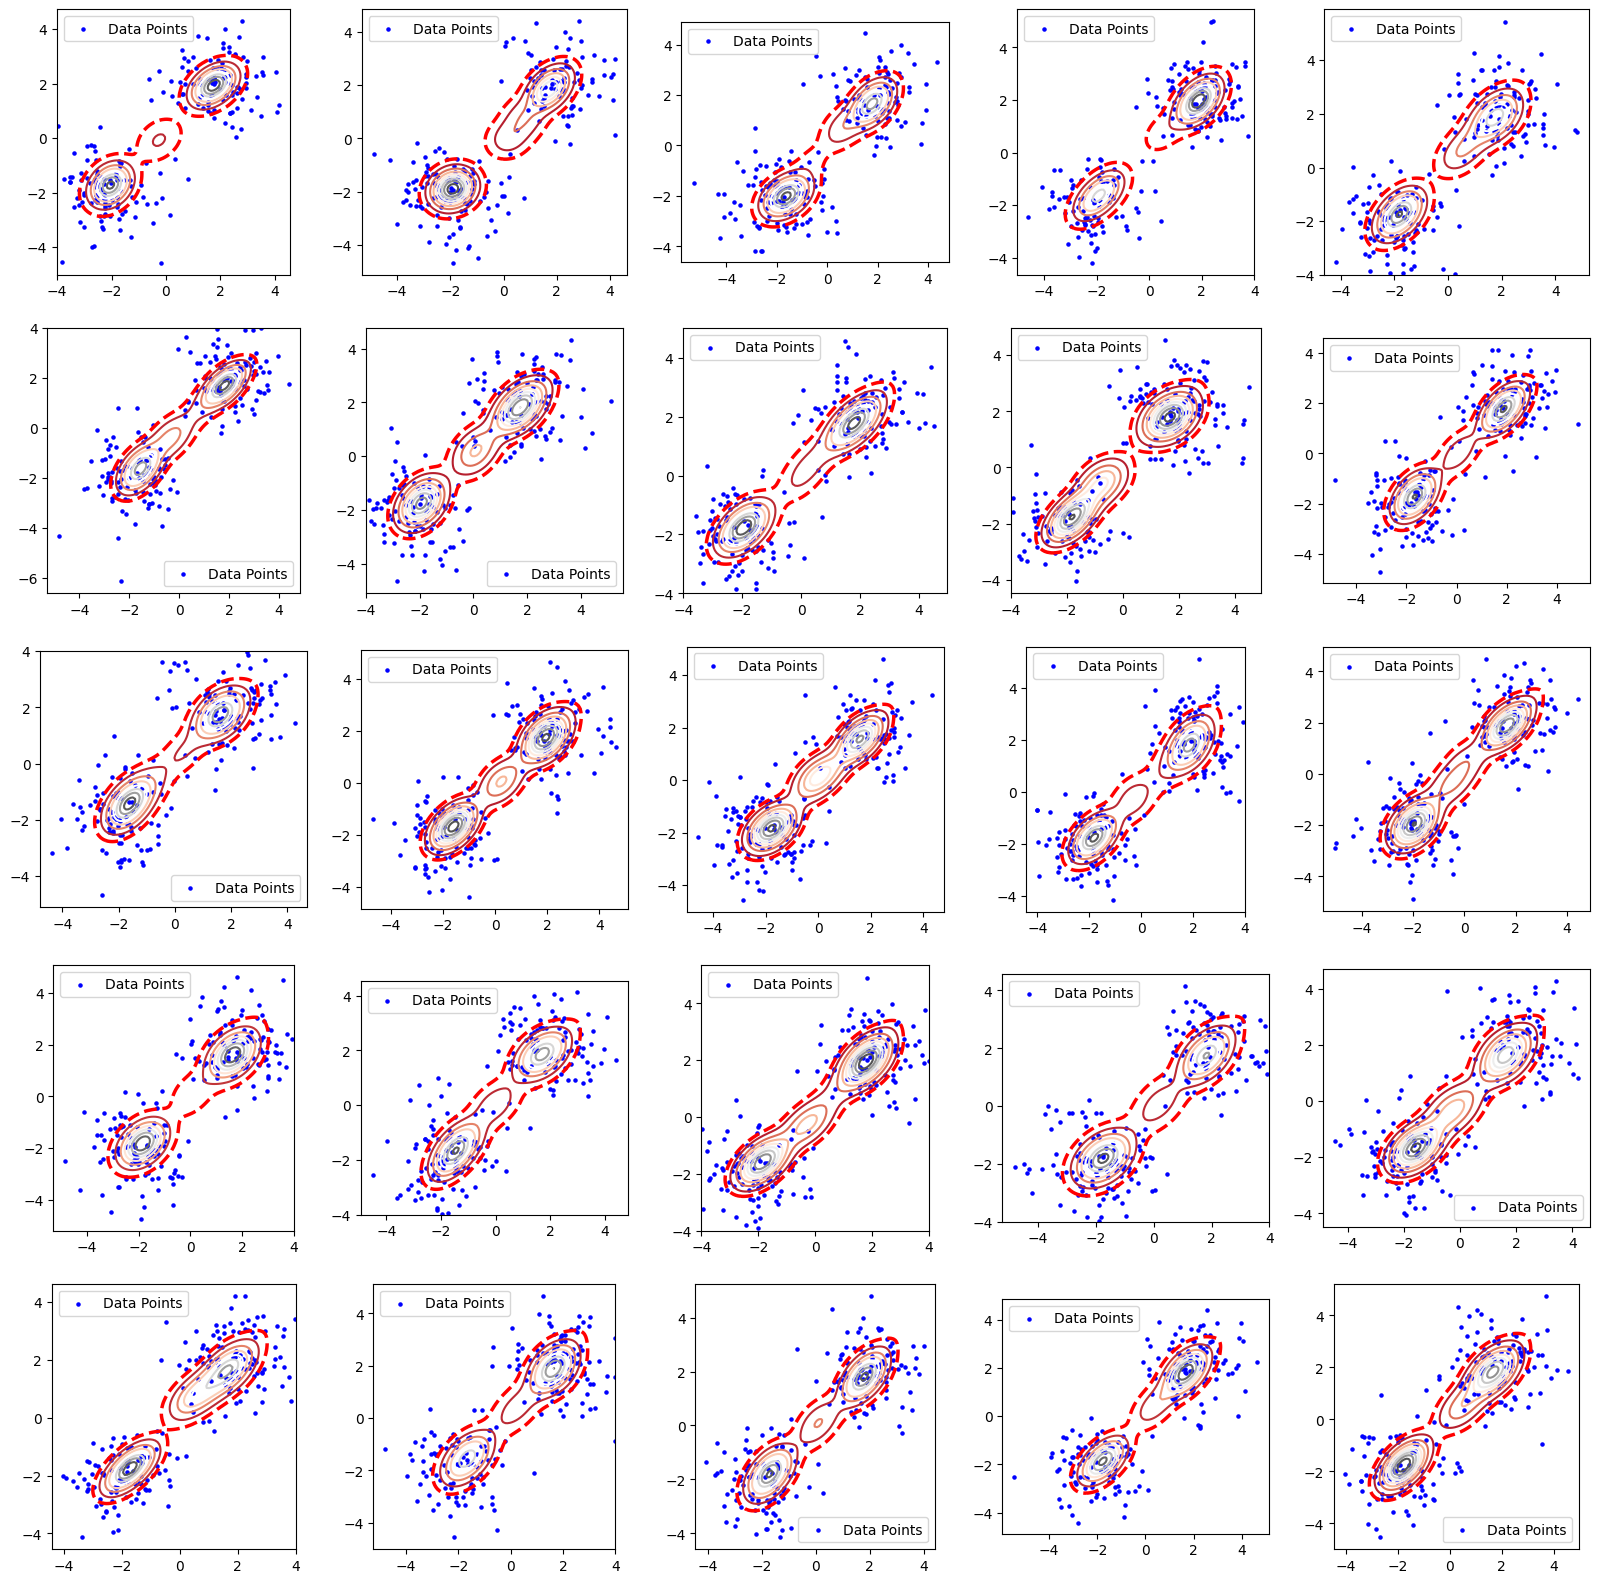

In [ ]:
fig, axs = plt.subplots(5, 5, figsize=(20, 20))

for ax, gmm, data in zip(axs.ravel(), gmminterp, datapoints):
    display_gmm_data(gmm, data = data, n=100, ax=-4, bx=4, ay=-4, by=4, cmap='RdGy', axis=ax)

plt.show()

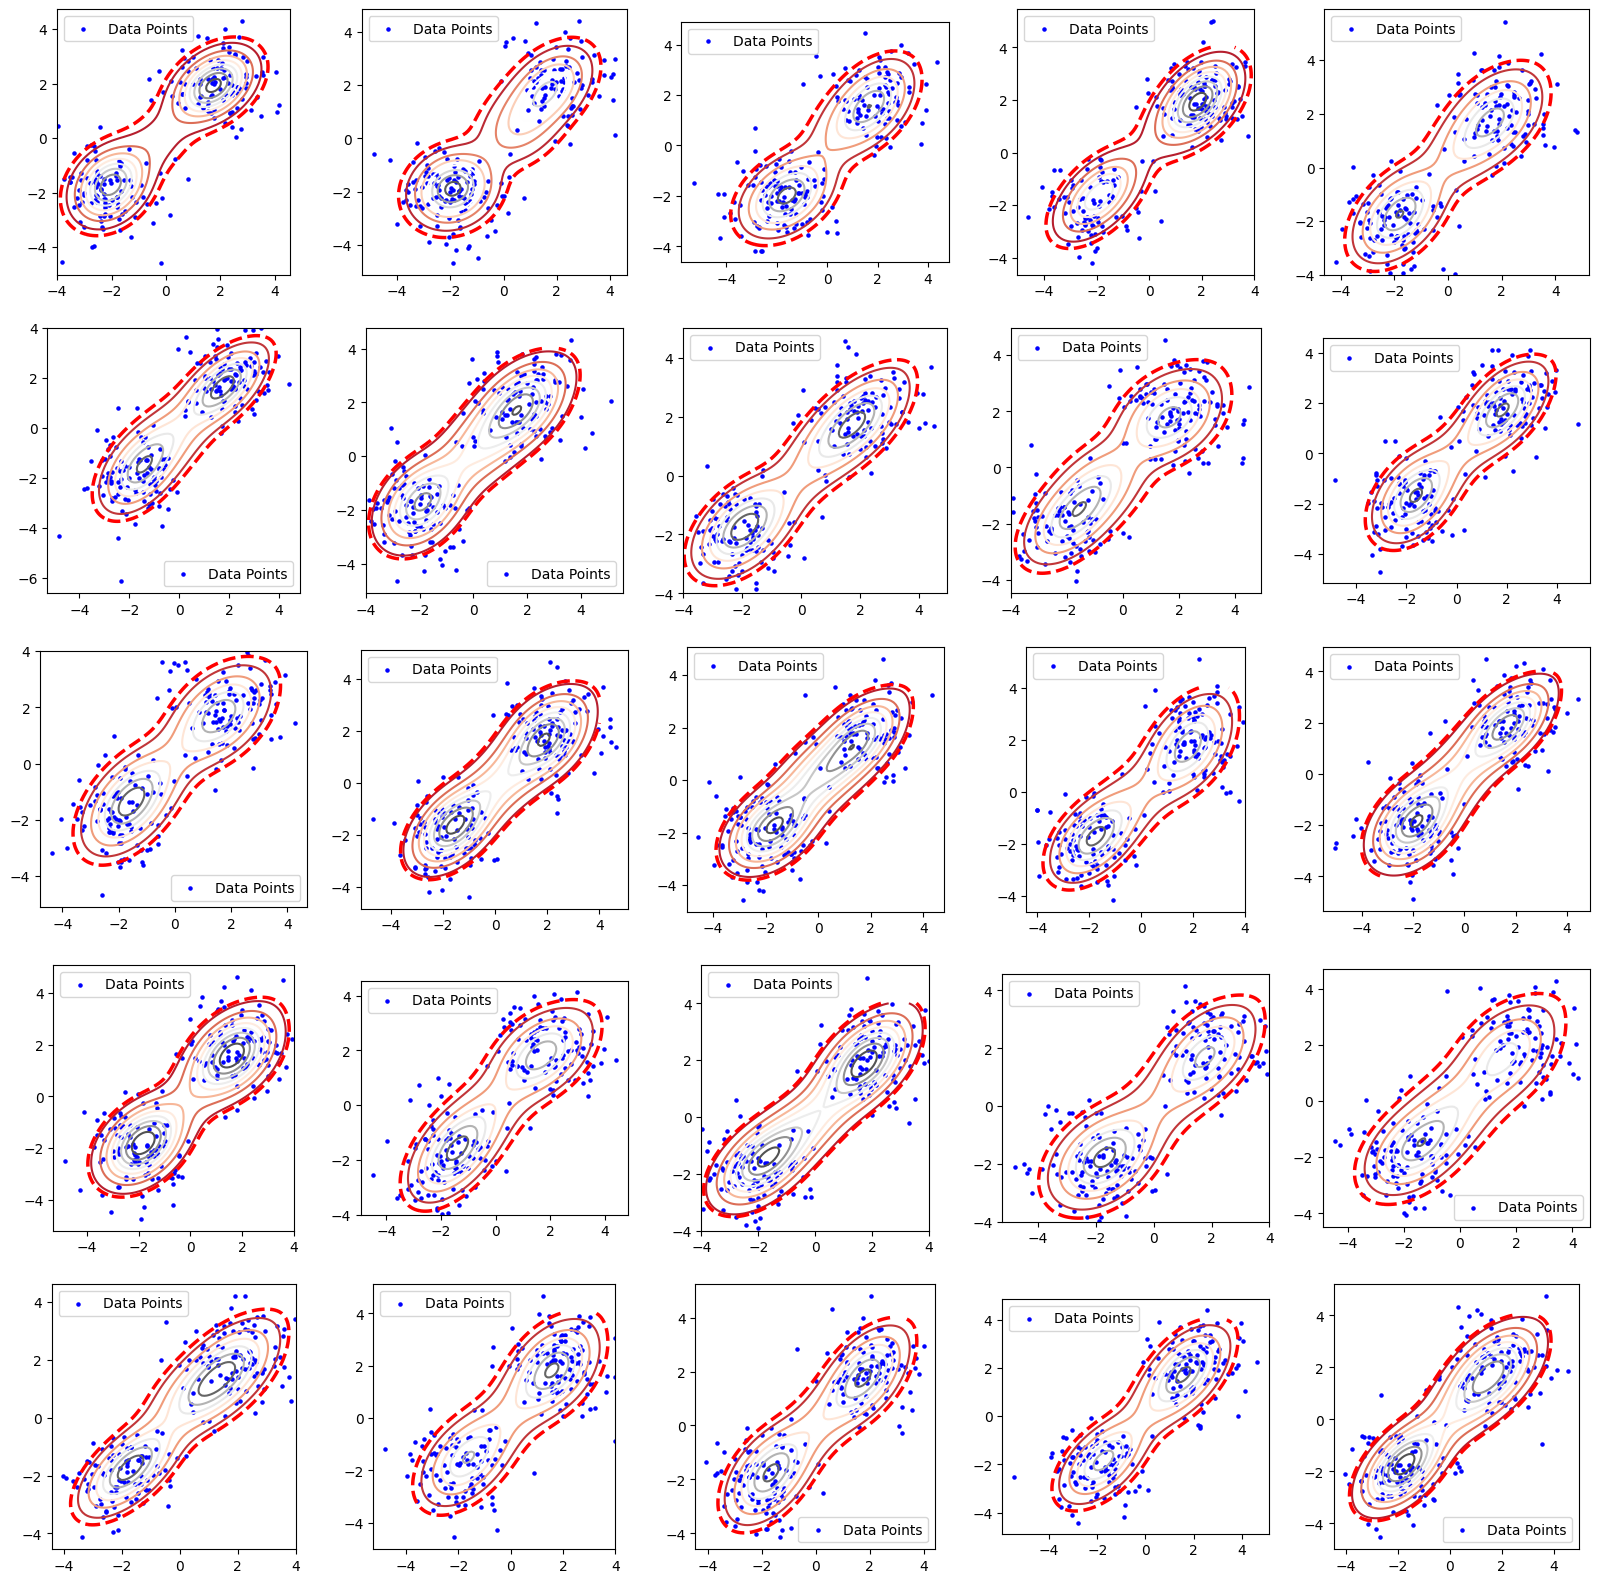

In [ ]:
fig, axs = plt.subplots(5, 5, figsize=(20, 20))

for ax, gmm, data in zip(axs.ravel(), gmminterp, datapoints):
    display_gmm_data(gmm, data = data, n=100, ax=-4, bx=4, ay=-4, by=4, cmap='RdGy', axis=ax)

plt.show()

In [ ]:
import numpy as np

def check_points_in_confidence_region(gmm, data_points, coverage=0.9):
    [K, pi, mu, S] = gmm

    # Calculate the density for a grid (this part you might already have from your contour plot code)
    x = np.linspace(-4, 4, num=50)
    y = np.linspace(-4, 4, num=50)
    X, Y = np.meshgrid(x, y)
    XX = np.array([X.ravel(), Y.ravel()]).T
    Z = densite_theorique2d(mu, S, pi, XX)
    Z = Z.reshape(X.shape)

    # Get the density threshold for the desired coverage
    level = coverage_level(Z, pi, coverage)

    # Calculate the density at each data point
    data_density = densite_theorique2d(mu, S, pi, data_points)

    # Determine which points are inside the confidence region
    inside = data_density >= level
    return inside

# Example usage:
# gmm = [K, pi, mu, S]
# data_points = np.array([[x1, y1], [x2, y2], ...])
# inside = check_points_in_confidence_region(gmm, data_points)


In [ ]:
covm_95 = [0]*25
cov_95 = [0]*25
for i in range(25):
  covm_95[i] = sum(check_points_in_confidence_region(gmminterp[i], datapoints[i],coverage=0.95))/len(datapoints[i])
  cov_95[i] = sum(check_points_in_confidence_region(ori_gmm_list[i], datapoints[i],coverage=0.95))/len(datapoints[i])

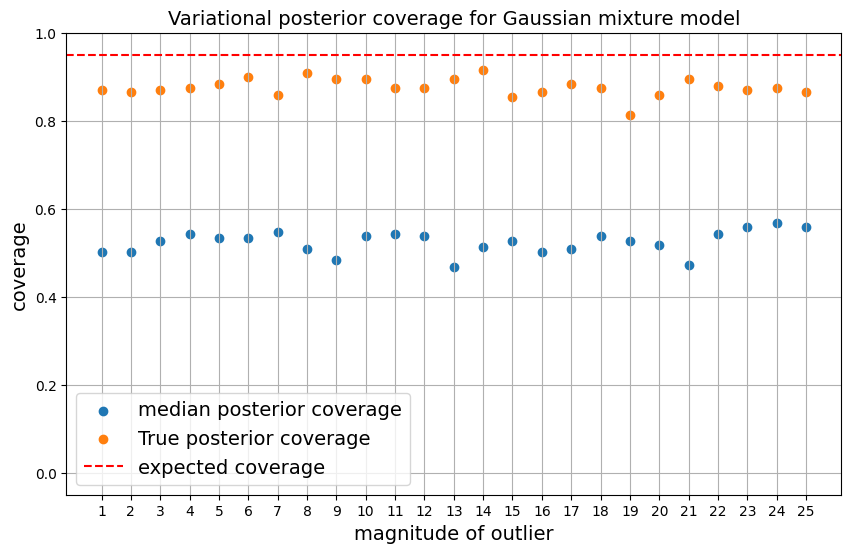

In [ ]:
import matplotlib.pyplot as plt

# Data
x_values = list(range(1, 26))  # x values from 1 to 15
plt.figure(figsize=(10, 6))
plt.scatter(x_values, covm_95, label='median posterior coverage')
plt.scatter(x_values, cov_95, label='True posterior coverage')

plt.axhline(y=0.95, color='r', linestyle='--', label='expected coverage')

plt.title('Variational posterior coverage for Gaussian mixture model', fontsize=14)
plt.xlabel('magnitude of outlier', fontsize=14)
plt.ylabel('coverage', fontsize=14)
plt.xticks(x_values)  # Ensure all x values are shown
plt.ylim(-0.05, 1)  # Setting the y-axis limit
plt.legend(fontsize=14)
plt.grid(True)
plt.show()

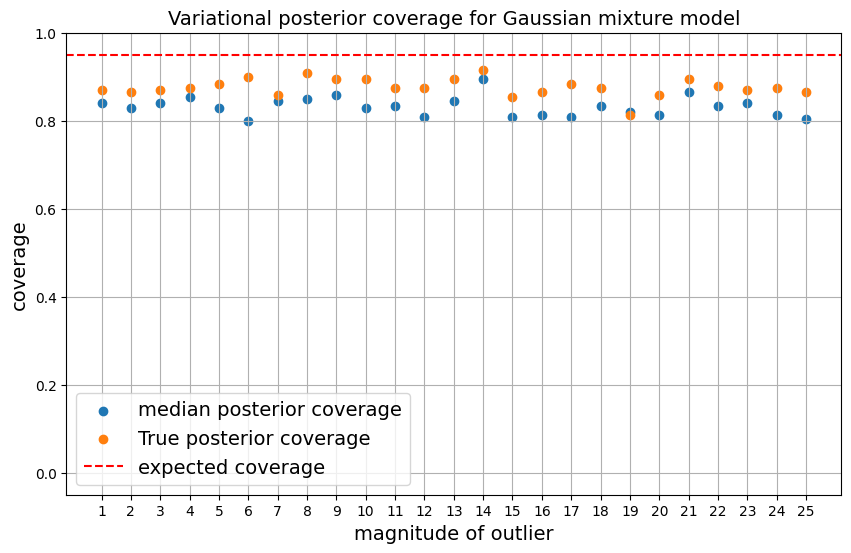

In [ ]:
import matplotlib.pyplot as plt

# Data
x_values = list(range(1, 26))  # x values from 1 to 15
plt.figure(figsize=(10, 6))
plt.scatter(x_values, covm_95, label='median posterior coverage')
plt.scatter(x_values, cov_95, label='True posterior coverage')

plt.axhline(y=0.95, color='r', linestyle='--', label='expected coverage')

plt.title('Variational posterior coverage for Gaussian mixture model', fontsize=14)
plt.xlabel('magnitude of outlier', fontsize=14)
plt.ylabel('coverage', fontsize=14)
plt.xticks(x_values)  # Ensure all x values are shown
plt.ylim(-0.05, 1)  # Setting the y-axis limit
plt.legend(fontsize=14)
plt.grid(True)
plt.show()

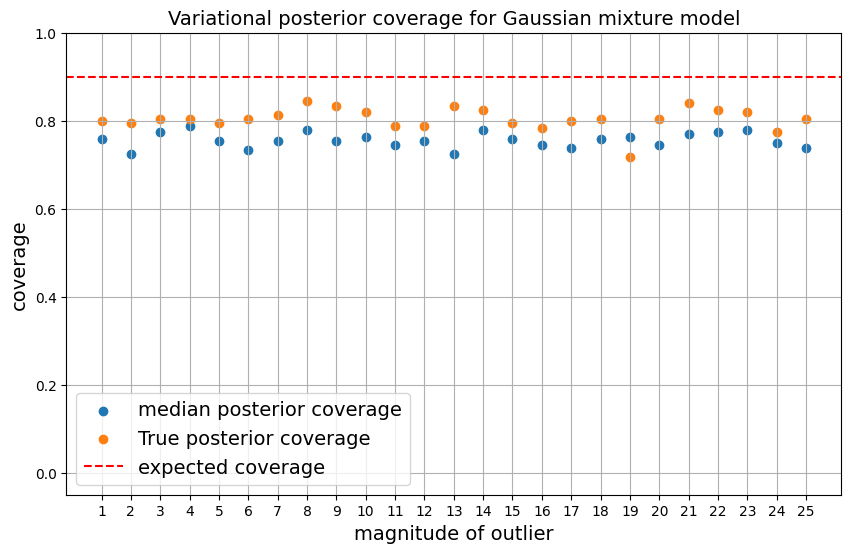

In [ ]:
covm_90 = [0]*25
cov_90 = [0]*25
for i in range(25):
  covm_90[i] = sum(check_points_in_confidence_region(gmminterp[i], datapoints[i],coverage=0.9))/len(datapoints[i])
  cov_90[i] = sum(check_points_in_confidence_region(ori_gmm_list[i], datapoints[i],coverage=0.9))/len(datapoints[i])

import matplotlib.pyplot as plt

# Data
x_values = list(range(1, 26))  # x values from 1 to 15
plt.figure(figsize=(10, 6))
plt.scatter(x_values, covm_90, label='median posterior coverage')
plt.scatter(x_values, cov_90, label='True posterior coverage')

plt.axhline(y=0.90, color='r', linestyle='--', label='expected coverage')

plt.title('Variational posterior coverage for Gaussian mixture model', fontsize=14)
plt.xlabel('magnitude of outlier', fontsize=14)
plt.ylabel('coverage', fontsize=14)
plt.xticks(x_values)  # Ensure all x values are shown
plt.ylim(-0.05, 1)  # Setting the y-axis limit
plt.legend(fontsize=14)
plt.grid(True)
plt.show()

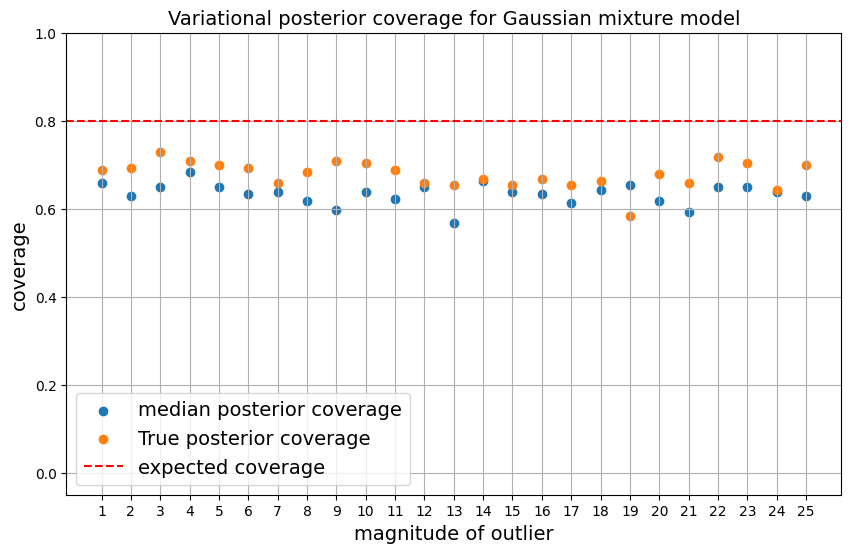

In [ ]:
covm_80 = [0]*25
cov_80 = [0]*25
for i in range(25):
  covm_80[i] = sum(check_points_in_confidence_region(gmminterp[i], datapoints[i],coverage=0.8))/len(datapoints[i])
  cov_80[i] = sum(check_points_in_confidence_region(ori_gmm_list[i], datapoints[i],coverage=0.8))/len(datapoints[i])

import matplotlib.pyplot as plt

# Data
x_values = list(range(1, 26))  # x values from 1 to 15
plt.figure(figsize=(10, 6))
plt.scatter(x_values, covm_80, label='median posterior coverage')
plt.scatter(x_values, cov_80, label='True posterior coverage')

plt.axhline(y=0.80, color='r', linestyle='--', label='expected coverage')

plt.title('Variational posterior coverage for Gaussian mixture model', fontsize=14)
plt.xlabel('magnitude of outlier', fontsize=14)
plt.ylabel('coverage', fontsize=14)
plt.xticks(x_values)  # Ensure all x values are shown
plt.ylim(-0.05, 1)  # Setting the y-axis limit
plt.legend(fontsize=14)
plt.grid(True)
plt.show()

#### method without median

In [ ]:
import pandas as pd
import numpy as np
gmm_result_df = pd.read_csv("/content/drive/MyDrive/VI/gmm_result.csv", delimiter=",")

In [ ]:
import numpy as np

# Re-running the extraction with numpy imported

# Reset our placeholder lists again
mus = []
pis = []
sigmas = []
K = 2

for i in range(0, 175, 7):  # Iterating with the correct pattern
    # Extract 'mu'
    mu = np.transpose(gmm_result_df.iloc[i:i+2, :].values)
    mus.append(mu)

    # Extract 'pi'
    pi = gmm_result_df.iloc[i + 2, :].values
    pis.append(pi)

    # Extract and reconstruct 'sigma'
    sigma_iteration = []
    for j in range(K):
        sigma_values = []
        sigma_values  = gmm_result_df.iloc[i+3:i+7,j].values
        sigma_values = sigma_values.reshape((2,2))
        sigma_values = sigma_values
        sigma_iteration.append(sigma_values)
    sigmas.append(sigma_iteration)

# Showing the corrected first 'mu', 'pi', and the first 'sigma' matrix for the first cluster of the first iteration for verification
mus[0], pis[0], sigmas[0]

pis_array = np.array(pis)
ori_gmm_list = []
for i in range(len(mus)):
    sigmas[i] = np.stack(sigmas[i], axis=0)
    ori_gmm_list.append([K,pis[i], mus[i], sigmas[i]])

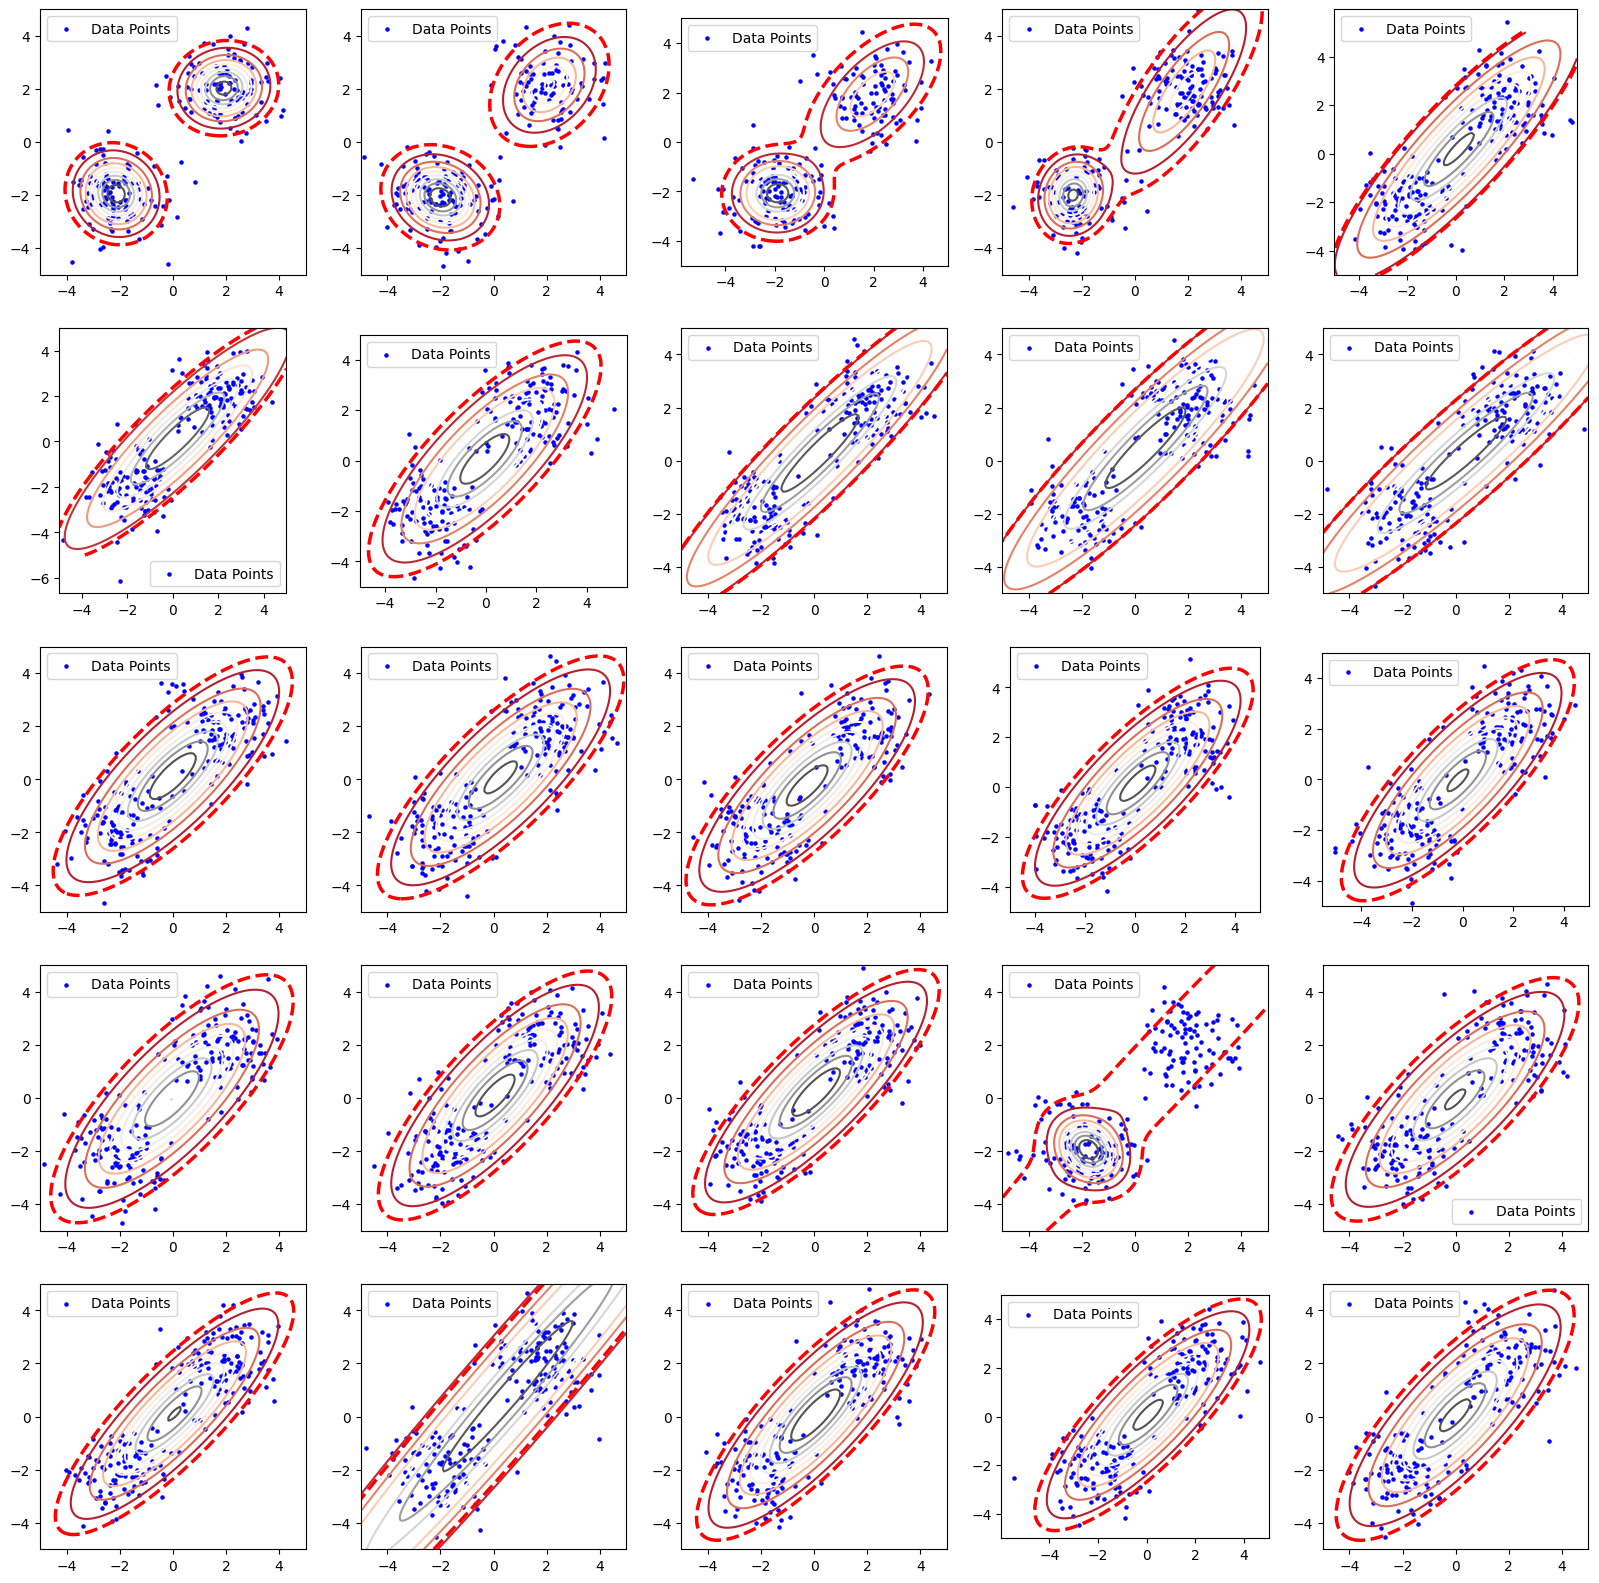

In [ ]:
fig, axs = plt.subplots(5, 5, figsize=(20, 20))

for ax, gmm, data in zip(axs.ravel(), ori_gmm_list, datapoints):
    display_gmm_data(gmm, data=data, n=100, ax=-5, bx=5, ay=-5, by=5, cmap='RdGy', axis=ax)

plt.show()

#### check coverage

In [ ]:
import scipy.stats as sps

def calculate_coverage(data, gmm, threshold=0.95):
    weights, means, covars = gmm[1], gmm[2], gmm[3]
    total_prob = np.zeros(data.shape[0])

    for weight, mean, covar in zip(weights, means, covars):
        rv = sps.multivariate_normal(mean, covar)
        total_prob += weight * rv.pdf(data)

    # Determine the density threshold that captures the desired percentage of data
    density_threshold = np.percentile(total_prob, 100 * (1 - threshold))

    # Calculate coverage as the percentage of points above the threshold
    coverage = np.mean(total_prob > density_threshold)
    return coverage

In [ ]:

# Example usage:
coverage = calculate_coverage(datapoints[10], ori_gmm_list[10])
print(f"Coverage at 95% confidence level: {coverage * 100:.2f}%")


Coverage at 95% confidence level: 94.97%


### load the data and do simulations

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import torch
torch.manual_seed(0)
path = "/content/drive/MyDrive/VI_median"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
gmm_result_df = pd.read_csv(f"/content/drive/MyDrive/VI/gmm_result{i}.csv", delimiter=",")

In [ ]:
import numpy as np

# Re-running the extraction with numpy imported

# Reset our placeholder lists again
mus = []
pis = []
sigmas = []
K = 2

for i in range(0, 70, 7):  # Iterating with the correct pattern
    # Extract 'mu'
    mu = np.transpose(gmm_result_df.iloc[i:i+2, :].values)
    mus.append(mu)

    # Extract 'pi'
    pi = gmm_result_df.iloc[i + 2, :].values
    pis.append(pi)

    # Extract and reconstruct 'sigma'
    sigma_iteration = []
    for j in range(K):
        sigma_values = []
        sigma_values  = gmm_result_df.iloc[i+3:i+7,j].values
        sigma_values = sigma_values.reshape((2,2))
        sigma_values = sigma_values/10**(1/2)
        sigma_iteration.append(sigma_values)
    sigmas.append(sigma_iteration)

# Showing the corrected first 'mu', 'pi', and the first 'sigma' matrix for the first cluster of the first iteration for verification
mus[0], pis[0], sigmas[0]

pis_array = np.array(pis)
gmm_list = []
for i in range(len(mus)):
    sigmas[i] = np.stack(sigmas[i], axis=0)
    gmm_list.append([K,pis[i], mus[i], sigmas[i]])

In [ ]:
import numpy as np
import math

Kn = pow(K,len(mus))
d = 2
# Define the weights for the GMMs in the barycenter calculation
alpha = np.full(len(mus),1/len(mus))

gmminterp = []
C,mun,Sn   = create_cost_matrix_from_gmm(gmm_list,alpha)
pin        = solveMMOT(pis_array, C, epsilon = 1e-10).reshape(1,Kn)
mun,Sn     = mun.reshape(Kn,d),Sn.reshape(Kn,d,d)
gmminterp.append([Kn,pin,mun,Sn])



In [ ]:
non_zero_indices = [i for i, value in enumerate(gmminterp[0][1].flatten()) if value != 0]


In [ ]:
enumerate(gmminterp[0][1])

In [ ]:
non_zero_indices

[133, 144, 145, 146, 773, 781, 813, 877]

In [ ]:
gmminterp[0][1].flatten()[non_zero_indices]

array([4.99999508e-02, 4.99999500e-02, 1.14130927e-13, 4.00000100e-01,
       4.99999492e-02, 4.96663907e-02, 5.03335093e-02, 3.50000150e-01])

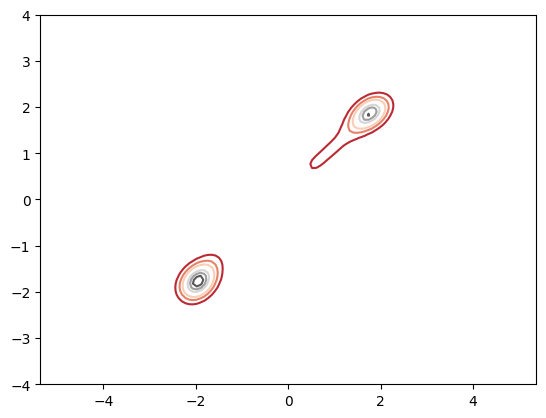

In [ ]:
display_gmm(gmminterp[0],cmap='RdGy',ax=-4,bx=4,ay=-4,by=4,n=100)

In [ ]:
import pandas as pd
import numpy as np
gmm_result_df = pd.read_csv("/content/drive/MyDrive/VI/gmm_result.csv", delimiter=",")

In [ ]:
import numpy as np

# Re-running the extraction with numpy imported

# Reset our placeholder lists again
mus = []
pis = []
sigmas = []
K = 2

for i in range(0, 175, 7):  # Iterating with the correct pattern
    # Extract 'mu'
    mu = np.transpose(gmm_result_df.iloc[i:i+2, :].values)
    mus.append(mu)

    # Extract 'pi'
    pi = gmm_result_df.iloc[i + 2, :].values
    pis.append(pi)

    # Extract and reconstruct 'sigma'
    sigma_iteration = []
    for j in range(K):
        sigma_values = []
        sigma_values  = gmm_result_df.iloc[i+3:i+7,j].values
        sigma_values = sigma_values.reshape((2,2))
        sigma_values = sigma_values
        sigma_iteration.append(sigma_values)
    sigmas.append(sigma_iteration)

# Showing the corrected first 'mu', 'pi', and the first 'sigma' matrix for the first cluster of the first iteration for verification
mus[0], pis[0], sigmas[0]

pis_array = np.array(pis)
ori_gmm_list = []
for i in range(len(mus)):
    sigmas[i] = np.stack(sigmas[i], axis=0)
    ori_gmm_list.append([K,pis[i], mus[i], sigmas[i]])

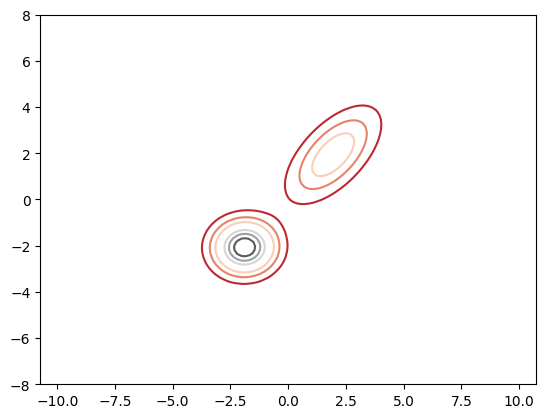

In [ ]:
display_gmm(ori_gmm_list[2],cmap='RdGy',ax=-8,bx=8,ay=-8,by=8,n=100)

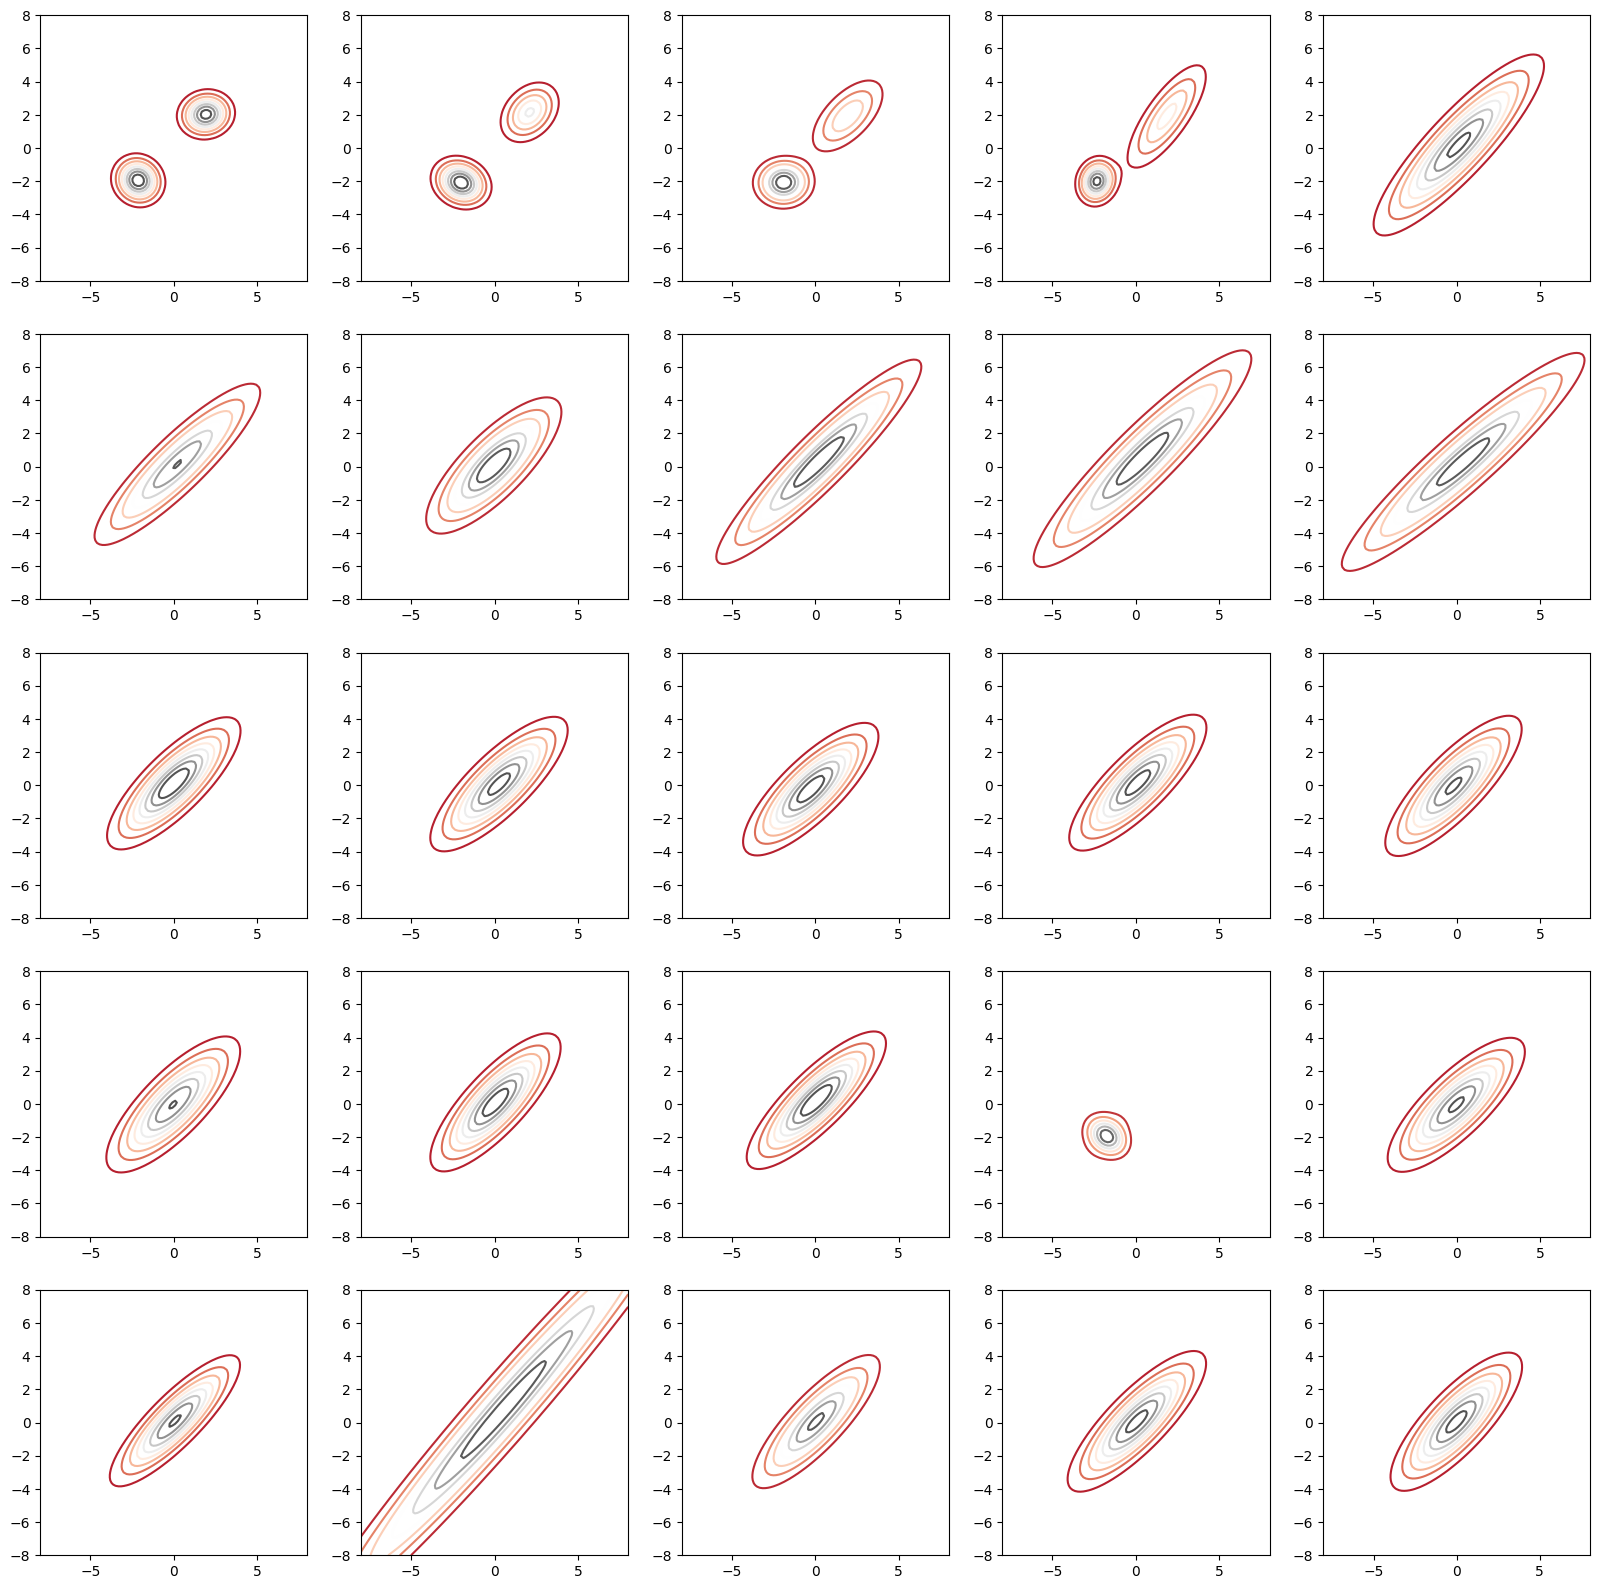

In [ ]:
fig, axs = plt.subplots(5, 5, figsize=(20, 20))  # Adjust size as needed

for ax, gmm in zip(axs.ravel(), ori_gmm_list):
    display_gmm(gmm, n=100, ax=-8, bx=8, ay=-8, by=8, cmap='RdGy', axis=ax)  # Corrected call

plt.show()

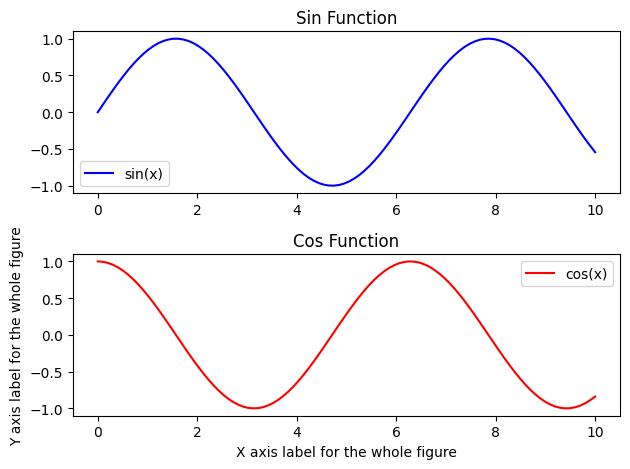

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some sample data
x = np.linspace(0, 10, 100)
y1 = np.sin(x)
y2 = np.cos(x)

# Create subplots
fig, axs = plt.subplots(2)  # 2 rows of plots

# Plot data on the first subplot with a label
axs[0].plot(x, y1, color='blue', label='sin(x)')
axs[0].set_title('Sin Function')

# Plot data on the second subplot with a label
axs[1].plot(x, y2, color='red', label='cos(x)')
axs[1].set_title('Cos Function')

# Add legend to each subplot
axs[0].legend()
axs[1].legend()

# Set x and y labels for the entire figure
plt.xlabel('X axis label for the whole figure')
plt.ylabel('Y axis label for the whole figure')

# Show the plots
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


## Real data set

#### penguins

In [ ]:
def loaddatasetfromcvs(file):
    for i in range(1,26):
        gmm_result_df = pd.read_csv(file, delimiter=",")
        mus = []
        pis = []
        sigmas = []
        K = 2

        for i in range(0, 70, 7):  # Iterating with the correct pattern
            # Extract 'mu'
            mu = np.transpose(gmm_result_df.iloc[i:i+2, :].values)
            mus.append(mu)

            # Extract 'pi'
            pi = gmm_result_df.iloc[i + 2, :].values
            pis.append(pi)

            # Extract and reconstruct 'sigma'
            sigma_iteration = []
            for j in range(K):
                sigma_values = []
                sigma_values  = gmm_result_df.iloc[i+3:i+7,j].values
                sigma_values = sigma_values.reshape((2,2))
                sigma_values = sigma_values*10**(1/2)
                sigma_iteration.append(sigma_values)
            sigmas.append(sigma_iteration)

        # Showing the corrected first 'mu', 'pi', and the first 'sigma' matrix for the first cluster of the first iteration for verification
        mus[0], pis[0], sigmas[0]

        pis_array = np.array(pis)
        gmm_list = []
        for i in range(len(mus)):
            sigmas[i] = np.stack(sigmas[i], axis=0)
            gmm_list.append([K,pis[i], mus[i], sigmas[i]])

    return pis_array, gmm_list


In [ ]:
gmminterp = []

file = f"/content/drive/MyDrive/VI/penguins_result.csv"
pis_array, gmm_list = loaddatasetfromcvs(file)
K = 2
Kn = pow(K,10)
d = 2
# Define the weights for the GMMs in the barycenter calculation
alpha = np.full(10,1/10)

C,mun,Sn   = create_cost_matrix_from_gmm(gmm_list,alpha)
pin        = solveMMOT(pis_array, C, epsilon = 1e-10).reshape(1,Kn)
mun,Sn     = mun.reshape(Kn,d),Sn.reshape(Kn,d,d)
gmminterp.append([Kn,pin,mun,Sn])


In [ ]:
import pandas as pd
import numpy as np
gmm_result_df = pd.read_csv("/content/drive/MyDrive/VI/ori_penguins_result.csv", delimiter=",")

import numpy as np

# Re-running the extraction with numpy imported

# Reset our placeholder lists again
mus = []
pis = []
sigmas = []
K = 2

for i in range(0, 7, 7):  # Iterating with the correct pattern
    # Extract 'mu'
    mu = np.transpose(gmm_result_df.iloc[i:i+2, :].values)
    mus.append(mu)

    # Extract 'pi'
    pi = gmm_result_df.iloc[i + 2, :].values
    pis.append(pi)

    # Extract and reconstruct 'sigma'
    sigma_iteration = []
    for j in range(K):
        sigma_values = []
        sigma_values  = gmm_result_df.iloc[i+3:i+7,j].values
        sigma_values = sigma_values.reshape((2,2))
        sigma_values = sigma_values
        sigma_iteration.append(sigma_values)
    sigmas.append(sigma_iteration)

# Showing the corrected first 'mu', 'pi', and the first 'sigma' matrix for the first cluster of the first iteration for verification
mus[0], pis[0], sigmas[0]

pis_array = np.array(pis)
ori_gmm_list = []
for i in range(len(mus)):
    sigmas[i] = np.stack(sigmas[i], axis=0)
    ori_gmm_list.append([K,pis[i], mus[i], sigmas[i]])

In [ ]:
file = f"/content/drive/MyDrive/VI/penguins_size.csv"
datapoint = pd.read_csv(file, delimiter=",")
data = datapoint.dropna()[0:299]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


def coverage_level(Z, pi, coverage=0.95):
    # Flatten the density matrix and sort it
    sorted_Z = np.sort(Z.ravel())[::-1]
    # Compute the cumulative density
    cumulative_density = np.cumsum(sorted_Z) / np.sum(sorted_Z)
    # Find the minimum density level that includes at least the 'coverage' fraction of total density
    return sorted_Z[np.argmax(cumulative_density >= coverage)]

def display_gmm_data(gmm, data=None, coverage=0.95, n=50, ax=0, bx=1, ay=0, by=1, cmap='viridis', axis=None):
    if axis is None:
        axis = plt.gca()

    [K, pi, mu, S] = gmm

    x = np.linspace(ax, bx, num=n)
    y = np.linspace(ay, by, num=n)
    X, Y = np.meshgrid(x, y)
    XX = np.array([X.ravel(), Y.ravel()]).T
    Z = densite_theorique2d(mu, S, pi, XX)
    Z = Z.reshape(X.shape)

    # Determine the contour level for the specified coverage
    level = coverage_level(Z, pi, coverage)

    # Plot the full density contour and the coverage contour
    contour_full = axis.contour(X, Y, Z, levels=8, cmap=cmap)
    contour_coverage = axis.contour(X, Y, Z, levels=[level], colors='red', linewidths=2.5, linestyles='dashed')
    axis.set_aspect('equal')

    # Plot data points if provided
    if data is not None:
        species_colors = {
            'Adelie': 'blue',
            'Chinstrap': 'green',
            'Gentoo': 'green'
        }

        # Iterate over species and colors to plot each species separately
        for species, color in species_colors.items():
            species_data = data[data['species'] == species]
            axis.scatter(species_data['culmen_length_mm'], species_data['culmen_depth_mm'], s=5, c=color, label=species)

        # Add legend for colors
        axis.legend(title='Species')

    return contour_full, contour_coverage


In [ ]:
data

species     island  culmen_length_mm  culmen_depth_mm  flipper_length_mm  \
0    Adelie  Torgersen              39.1             18.7              181.0   
1    Adelie  Torgersen              39.5             17.4              186.0   
2    Adelie  Torgersen              40.3             18.0              195.0   
4    Adelie  Torgersen              36.7             19.3              193.0   
5    Adelie  Torgersen              39.3             20.6              190.0   
..      ...        ...               ...              ...                ...   
302  Gentoo     Biscoe              47.4             14.6              212.0   
303  Gentoo     Biscoe              50.0             15.9              224.0   
304  Gentoo     Biscoe              44.9             13.8              212.0   
305  Gentoo     Biscoe              50.8             17.3              228.0   
306  Gentoo     Biscoe              43.4             14.4              218.0   

     body_mass_g     sex  
0         3750.0    MALE  
1         3800.0  FEMALE  
2         3250.0  FEMALE  
4         3450.0  FEMALE  
5         3650.0    MALE  
..           ...     ...  
302       4725.0  FEMALE  
303       5350.0    MALE  
304       4750.0  FEMALE  
305       5600.0    MALE  
306       4600.0  FEMALE  

[299 rows x 7 columns]

(<matplotlib.contour.QuadContourSet at 0x7c51348a2020>,
 <matplotlib.contour.QuadContourSet at 0x7c513431ca90>)

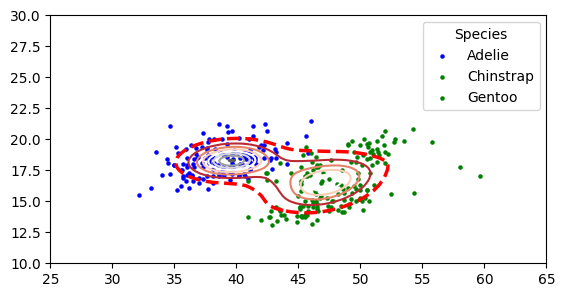

In [ ]:
display_gmm_data(gmminterp[0],data =data, n=100, ax=25, bx=65, ay=10, by=30, cmap='RdGy')


(<matplotlib.contour.QuadContourSet at 0x783cd205fca0>,
 <matplotlib.contour.QuadContourSet at 0x783cd06fedd0>)

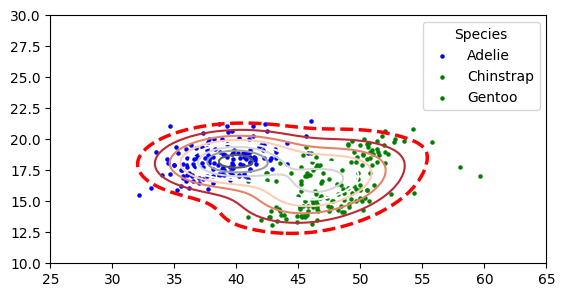

In [ ]:
display_gmm_data(gmminterp[0],data =data, n=100, ax=25, bx=65, ay=10, by=30, cmap='RdGy')


(<matplotlib.contour.QuadContourSet at 0x7c51345dc8e0>,
 <matplotlib.contour.QuadContourSet at 0x7c51345abc70>)

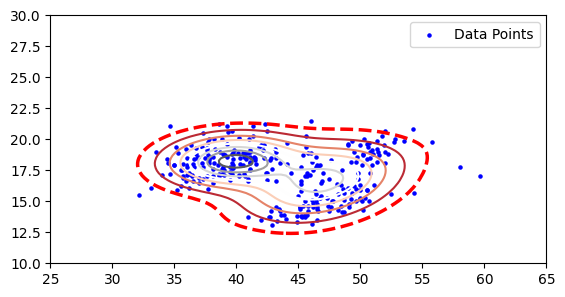

In [ ]:
display_gmm_data(gmminterp[0],data =data, n=100, ax=25, bx=65, ay=10, by=30, cmap='RdGy')


(<matplotlib.contour.QuadContourSet at 0x783b8ae23430>,
 <matplotlib.contour.QuadContourSet at 0x783b8ac4a170>)

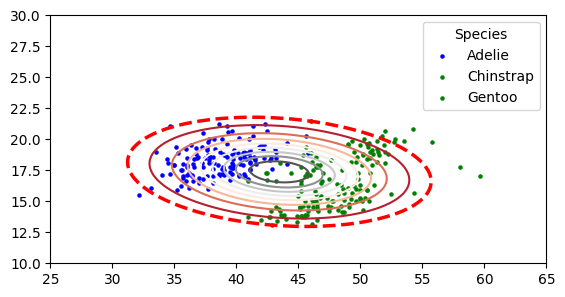

In [ ]:
display_gmm_data(ori_gmm_list[0],data =data, n=100, ax=25, bx=65, ay=10, by=30, cmap='RdGy')

#### penguis k3

In [ ]:
def loaddatasetfromcvs(file):
    for i in range(1,26):
        gmm_result_df = pd.read_csv(file, delimiter=",")
        mus = []
        pis = []
        sigmas = []
        K = 3

        for i in range(0, 70, 7):  # Iterating with the correct pattern
            # Extract 'mu'
            mu = np.transpose(gmm_result_df.iloc[i:i+2, :].values)
            mus.append(mu)

            # Extract 'pi'
            pi = gmm_result_df.iloc[i + 2, :].values
            pis.append(pi)

            # Extract and reconstruct 'sigma'
            sigma_iteration = []
            for j in range(K):
                sigma_values = []
                sigma_values  = gmm_result_df.iloc[i+3:i+7,j].values
                sigma_values = sigma_values.reshape((2,2))
                #sigma_values = sigma_values*10**(1/2)
                sigma_iteration.append(sigma_values)
            sigmas.append(sigma_iteration)

        # Showing the corrected first 'mu', 'pi', and the first 'sigma' matrix for the first cluster of the first iteration for verification
        mus[0], pis[0], sigmas[0]

        pis_array = np.array(pis)
        gmm_list = []
        for i in range(len(mus)):
            sigmas[i] = np.stack(sigmas[i], axis=0)
            gmm_list.append([K,pis[i], mus[i], sigmas[i]])

    return pis_array, gmm_list


In [ ]:
gmminterp = []

file = f"/content/drive/MyDrive/VI/k3_penguins_result.csv"
pis_array, gmm_list = loaddatasetfromcvs(file)
K = 3
Kn = pow(K,10)
d = 2
# Define the weights for the GMMs in the barycenter calculation
alpha = np.full(10,1/10)

C,mun,Sn   = create_cost_matrix_from_gmm(gmm_list,alpha)
pin        = solveMMOT(pis_array, C, epsilon = 1e-10).reshape(1,Kn)
mun,Sn     = mun.reshape(Kn,d),Sn.reshape(Kn,d,d)
gmminterp.append([Kn,pin,mun,Sn])

(<matplotlib.contour.QuadContourSet at 0x783b893ee8f0>,
 <matplotlib.contour.QuadContourSet at 0x783b8930e4d0>)

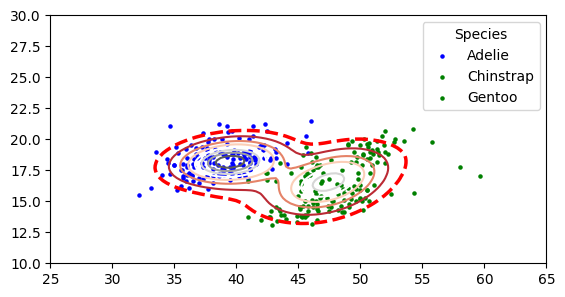

In [ ]:
display_gmm_data(gmminterp[0],data =data, n=100, ax=25, bx=65, ay=10, by=30, cmap='RdGy')


(<matplotlib.contour.QuadContourSet at 0x783b88f42f50>,
 <matplotlib.contour.QuadContourSet at 0x783b88f6f3a0>)

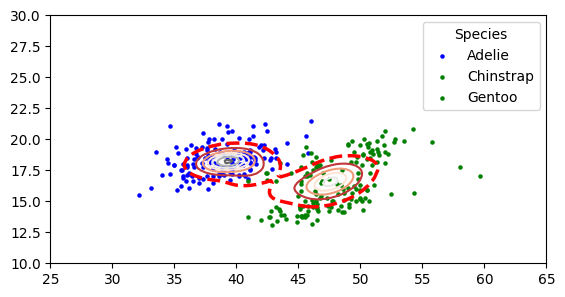

In [ ]:
display_gmm_data(gmminterp[0],data =data, n=100, ax=25, bx=65, ay=10, by=30, cmap='RdGy')


In [ ]:
import pandas as pd
import numpy as np
gmm_result_df = pd.read_csv("/content/drive/MyDrive/VI/k3_ori_penguins_result.csv", delimiter=",")

import numpy as np

# Re-running the extraction with numpy imported

# Reset our placeholder lists again
mus = []
pis = []
sigmas = []
K = 3

for i in range(0, 7, 7):  # Iterating with the correct pattern
    # Extract 'mu'
    mu = np.transpose(gmm_result_df.iloc[i:i+2, :].values)
    mus.append(mu)

    # Extract 'pi'
    pi = gmm_result_df.iloc[i + 2, :].values
    pis.append(pi)

    # Extract and reconstruct 'sigma'
    sigma_iteration = []
    for j in range(K):
        sigma_values = []
        sigma_values  = gmm_result_df.iloc[i+3:i+7,j].values
        sigma_values = sigma_values.reshape((2,2))
        sigma_values = sigma_values
        sigma_iteration.append(sigma_values)
    sigmas.append(sigma_iteration)

# Showing the corrected first 'mu', 'pi', and the first 'sigma' matrix for the first cluster of the first iteration for verification
mus[0], pis[0], sigmas[0]

pis_array = np.array(pis)
ori_gmm_list = []
for i in range(len(mus)):
    sigmas[i] = np.stack(sigmas[i], axis=0)
    ori_gmm_list.append([K,pis[i], mus[i], sigmas[i]])

(<matplotlib.contour.QuadContourSet at 0x783b8ad24910>,
 <matplotlib.contour.QuadContourSet at 0x783b8926e2f0>)

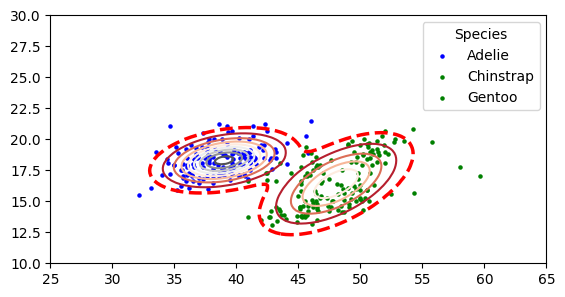

In [ ]:
display_gmm_data(ori_gmm_list[0],data =data, n=100, ax=25, bx=65, ay=10, by=30, cmap='RdGy')

##